In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import argparse
import torch
import torch.optim as optim
import numpy as np
from bisect import bisect
import matplotlib.pyplot as plt

import datetime
import torch.nn as nn
import wandb

sys.path.append(f"{os.path.dirname(os.getcwd())}")

from src.dataset_large import ProtoPlanetaryDisks
from src.ae_model_phy import *
from src.utils import count_parameters, str2bool, plot_recon_wall, plot_latent_space
from src.training_callbacks import EarlyStopping

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.empty_cache()

In [4]:
rnd_seed = 13
np.random.seed(rnd_seed)
torch.manual_seed(rnd_seed)
torch.cuda.manual_seed_all(rnd_seed)

In [5]:
batch_size = 64

latent_dim   = 8
dropout      = 0.2
kernel_size  = 3
conv_blocks  = 4
feed_phy     = False
lr = 1e-4

In [6]:
dataset = ProtoPlanetaryDisks(
            machine="local",
            transform=True,
            par_norm=True,
            subset="25052021",
            image_norm="image",
        )

In [7]:
dataset.par_train.shape

(58335, 8)

In [8]:
dataset.imgs_test.shape

(14584, 1, 187, 187)

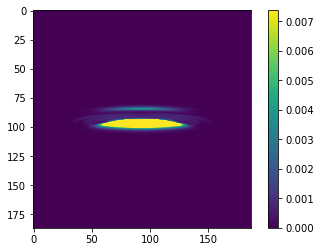

In [9]:
cbar = plt.imshow(dataset[0][0][0], vmin=0, vmax=np.percentile(dataset[0][0][0], 99))
plt.colorbar(cbar)
plt.show()

In [10]:
train_loader, val_loader, test_loader = dataset.get_dataloader(
        batch_size=batch_size, shuffle=True, val_split=0.2, random_seed=rnd_seed
    )

In [11]:
len(train_loader), len(val_loader), len(test_loader)

(730, 183, 228)

In [12]:
dataset.par_train.shape

(58335, 8)

In [13]:
autoencoder = ConvLinTrans_AE(
            latent_dim=latent_dim,
            img_dim=dataset.img_dim,
            dropout=dropout,
            in_ch=dataset.img_channels,
            kernel=kernel_size,
            n_conv_blocks=conv_blocks,
            phy_dim=len(dataset.par_names) if str2bool(feed_phy) else 0,
            feed_phy=str2bool(feed_phy),
        )

In [14]:
optimizer = optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=1e-6)

In [15]:
class Regressor(nn.Module):
    
    def __init__(
        self,
        input_dim=8,
        output_dim=8,
        dropout=0.2,
        n_layers=4,
    ):
        super(Regressor, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.n_layers = n_layers
        
        self.fc_layers = nn.Sequential()
        for k in range(n_layers):
            self.fc_layers.add_module(f"fc_{k+1}", 
                                      nn.Linear(self.input_dim, self.output_dim)
                                     )
            self.fc_layers.add_module(f"tanh_{k+1}", nn.Tanh())
        
    def forward(self, x):
        return self.fc_layers(x)
    
    def inverse(self, y):
        '''
            Returns the invert of the NN. Only works if all layers have the same 
            number of input and output neurons. Only implemented for Linear
            layers and Tanh activation function. 
        '''
        if self.input_dim != self.output_dim:
            raise ValueError("FC layers have different input/output number of neurons")
            
        z = y  # use 'z' for the reverse result, start with the model's output 'y'.
        for step in list(self.fc_layers.children())[::-1]:
            if isinstance(step, torch.nn.Linear):
                z = z - step.bias[None, ...]
                z = z[..., None]  # 'torch.solve' requires N column vectors (i.e. shape (N, n, 1)).
                # z = torch.solve(z, step.weight)[0]
                z = torch.linalg.solve(step.weight, z)
                z = torch.squeeze(z)  # remove the extra dimension that we've added for 'torch.solve'.
            elif isinstance(step, torch.nn.Tanh):
                z = 0.5 * torch.log((1 + z) / (1 - z))
            else:
                raise ValueError(f"Layer {step} not implemented")
                
        return z
        

In [16]:
N = len(dataset.par_names)
regressor_nlayers = 4

x_test = torch.randn(64, N)
regres = Regressor(input_dim=N, output_dim=N, n_layers=regressor_nlayers)
regres

Regressor(
  (fc_layers): Sequential(
    (fc_1): Linear(in_features=8, out_features=8, bias=True)
    (tanh_1): Tanh()
    (fc_2): Linear(in_features=8, out_features=8, bias=True)
    (tanh_2): Tanh()
    (fc_3): Linear(in_features=8, out_features=8, bias=True)
    (tanh_3): Tanh()
    (fc_4): Linear(in_features=8, out_features=8, bias=True)
    (tanh_4): Tanh()
  )
)

In [17]:
y = regres(x_test)
z = regres.inverse(y)
print('Agreement between x and z: ', torch.dist(x_test, z))

Agreement between x and z:  tensor(0.0160, grad_fn=<DistBackward0>)


In [38]:
class Trainer(object):

    def __init__(
        self,
        autoencoder,
        regressor,
        optimizer,
        batch_size,
        wandb,
        scheduler=None,
        print_every=50,
        loss_fx="bce",
        device="cpu",
        dry_run=False,
    ):
        self.device = device
        self.autoencoder = autoencoder
        self.regressor = regressor
        if torch.cuda.device_count() > 1 and True:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            self.autoencoder = nn.DataParallel(self.autoencoder)
            self.regressor = nn.DataParallel(self.regressor)
        self.autoencoder.to(self.device)
        self.regressor.to(self.device)
        print("Is model in cuda? ", next(self.autoencoder.parameters()).is_cuda)
        self.opt = optimizer
        self.sch = scheduler
        self.batch_size = batch_size
        self.train_loss = {"Loss_AE": [], "Loss_R": [], "Loss": []}
        self.test_loss = {"Loss_AE": [], "Loss_R": [], "Loss": []}
        self.num_steps = 0
        self.print_every = print_every
        self.mse_loss = nn.MSELoss(reduction="mean")
        self.bce_loss = nn.BCELoss(reduction="mean")
        self.wb = wandb
        self.loss_fx = loss_fx
        self.dry_run = dry_run

    def _loss(self, x, xhat, phy, phyhat, train=True, ep=0):
        if self.loss_fx == "mse":
            loss_recon = self.mse_loss(xhat, x)
            loss_regre = self.mse_loss(phyhat, phy)
        elif self.loss_fx == "bce":
            loss_recon = self.bce_loss(xhat, x)
            loss_regre = self.bce_loss(phyhat, phy)
        loss = loss_recon + loss_regre

        if train:
            self.train_loss["Loss_AE"].append(loss_recon.item())
            self.train_loss["Loss_R"].append(loss_regre.item())
            self.train_loss["Loss"].append(loss.item())
        else:
            self.test_loss["Loss_AE"].append(loss_recon.item())
            self.test_loss["Loss_R"].append(loss_regre.item())
            self.test_loss["Loss"].append(loss.item())

        return loss

    def _train_epoch(self, data_loader, epoch):
        # switch model to training mode
        self.autoencoder.train()
        self.regressor.train()
        # iterate over len(data)/batch_size
        z_all = []
        xhat_plot, x_plot = [], []
        for i, (img, phy) in enumerate(data_loader):
            self.num_steps += 1
            self.opt.zero_grad()
            img = img.to(self.device)
            phy = phy.to(self.device)

            # eval autoencoder
            xhat, z = self.autoencoder(img)
            # eval regressor
            phyhat = self.regressor(phy)
            
            # calculate loss value
            loss = self._loss(img, xhat, phy, phyhat, train=True, ep=epoch)
            
            # calculate the gradients
            loss.backward()
            
            # perform optimization step accordig to the gradients
            self.opt.step()

            self._report_train(i)
            # aux variables for latter plots
            z_all.append(z.data.cpu().numpy())
            if i == 10:
                xhat_plot = xhat.data.cpu().numpy()
                x_plot = img.data.cpu().numpy()
            if i == 100 and self.dry_run:
               print('WARNING: using only 1st batch')
               break

        z_all = np.concatenate(z_all)
        z_all = z_all[np.random.choice(z_all.shape[0], 3000, replace=False), :]
        # print(z_all.shape)

        # plot reconstructed images ever 2 epochs
        if epoch % 2 == 0:
            wall = plot_recon_wall(xhat_plot, x_plot, epoch=epoch, log=True)
            self.wb.log({"Train_Recon": self.wb.Image(wall)}, step=self.num_steps)

        if epoch % 2 == 0:
            latent_plot = plot_latent_space(z_all, y=None)
            self.wb.log(
                {"Latent_space": self.wb.Image(latent_plot)}, step=self.num_steps
            )

    def _test_epoch(self, test_loader, epoch):
        
        # swich model to evaluation mode, this make it deterministic
        self.autoencoder.eval()
        self.regressor.eval()
        with torch.no_grad():
            xhat_plot, x_plot = [], []

            for i, (img, phy) in enumerate(test_loader):
                # send data to current device
                img = img.to(self.device)
                phy = phy.to(self.device)
                # evaluate autoencoder
                xhat, z = self.autoencoder(img)
                # eval regressor
                phyhat = self.regressor(phy)
                # calculate loss value
                loss = self._loss(img, xhat, phy, phyhat, train=False, ep=epoch)

                # aux variables for plots
                if i == 10:
                    xhat_plot = xhat.data.cpu().numpy()
                    x_plot = img.data.cpu().numpy()
                if i == 100 and self.dry_run:
                   print('WARNING: using only 1st batch')
                   break

        self._report_test(epoch)

        # plot reconstructed images ever 2 epochs
        if epoch % 2 == 0:
            wall = plot_recon_wall(xhat_plot, x_plot, epoch=epoch, log=True)
            self.wb.log({"Test_Recon": self.wb.Image(wall)}, step=self.num_steps)

        return loss

    def train(self, train_loader, test_loader, epochs, save=True, early_stop=False):

        # hold samples, real and generated, for initial plotting
        if early_stop:
            early_stopping = EarlyStopping(patience=10, min_delta=0.1, verbose=True)

        # train for n number of epochs
        time_start = datetime.datetime.now()
        for epoch in range(1, epochs + 1):
            e_time = datetime.datetime.now()
            print("##" * 20)
            print("\nEpoch {}".format(epoch))

            # train and validate
            self._train_epoch(train_loader, epoch)
            val_loss = self._test_epoch(test_loader, epoch)

            # update learning rate according to cheduler
            if self.sch is not None:
                self.wb.log({"LR": self.opt.param_groups[0]["lr"]}, step=self.num_steps)
                if "ReduceLROnPlateau" == self.sch.__class__.__name__:
                    self.sch.step(val_loss)
                else:
                    self.sch.step()

            # report elapsed time per epoch and total run tume
            epoch_time = datetime.datetime.now() - e_time
            elap_time = datetime.datetime.now() - time_start
            print("Time per epoch: ", epoch_time.seconds, " s")
            print("Elapsed time  : %.2f m" % (elap_time.seconds / 60))
            print("##" * 20)

            # early stopping
            if early_stop:
                early_stopping(val_loss.cpu())
                if early_stopping.early_stop:
                    print("Early stopping")
                    break

        if save:
            torch.save(self.autoencoder.state_dict(), "%s/autoencoder.pt" % (self.wb.run.dir))
            torch.save(self.regressor.state_dict(), "%s/regressor.pt" % (self.wb.run.dir))

    def _report_train(self, i):
        # ------------------------ Reports ---------------------------- #
        # print scalars to std output and save scalars/hist to W&B
        if i % self.print_every == 0:
            print("Training iteration %i, global step %i" % (i + 1, self.num_steps))
            print("Loss AE: %.6f" % (self.train_loss["Loss_AE"][-1]))
            print("Loss R : %.6f" % (self.train_loss["Loss_R"][-1]))
            print("Loss   : %.6f" % (self.train_loss["Loss"][-1]))

            self.wb.log(
                {"Train_Loss": self.train_loss["Loss"][-1], 
                 "Train_Loss_AE": self.train_loss["Loss_AE"][-1], 
                 "Train_Loss_R": self.train_loss["Loss_R"][-1], 
                }, step=self.num_steps
            )
            print("__" * 20)

    def _report_test(self, ep):
        # ------------------------ Reports ---------------------------- #
        # print scalars to std output and save scalars/hist to W&B
        print("*** TEST LOSS ***")
        print("Epoch %i, global step %i" % (ep, self.num_steps))
        print("Loss: %.6f" % (self.test_loss["Loss"][-1]))

        self.wb.log({"Test_Loss_AE": self.test_loss["Loss_AE"][-1],
                     "Test_Loss_R": self.test_loss["Loss_R"][-1],
                     "Test_Loss": self.test_loss["Loss"][-1],
                    }, step=self.num_steps)
        print("__" * 20)


In [31]:
dry_run = True

In [21]:
wandb.init(entity="deep_ppd", project="dual-ae-regressor", tags=["develop"])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jorgemarpa (deep_ppd). Use `wandb login --relogin` to force relogin


In [29]:
wandb.config.update({
    "batch_size": batch_size,
    "latent_dim": latent_dim,
    "dropout": dropout,
    "kernel_size": kernel_size,
    "conv_blocks": conv_blocks,
    "feed_phy": str(feed_phy),
    "lr": lr,
    "img_channels": dataset.img_channels,
    "feed_phy": feed_phy,
    "rnd_seed": rnd_seed,
    "regressor_nlayers": regressor_nlayers,
    "physics_dim": len(dataset.par_names),
    "n_train_params_autoencoder": count_parameters(autoencoder),
    "n_train_params_regressor": count_parameters(regres),
    "dry_run": dry_run,
})
wandb.watch((autoencoder, regres), log="gradients")

[]

In [39]:
trainer = Trainer(
        autoencoder,
        regres,
        optimizer,
        batch_size,
        wandb,
        scheduler=None,
        print_every=100,
        device=device,
        loss_fx="mse",
        dry_run=dry_run,
    )

Is model in cuda?  False


In [40]:
for i, (img, phy) in enumerate(train_loader):
    print(img.shape, phy.shape)
    break

torch.Size([64, 1, 187, 187]) torch.Size([64, 8])


########################################

Epoch 1
Training iteration 1, global step 1
Loss AE: 0.001770
Loss R : 0.486884
Loss   : 0.488654
________________________________________
Training iteration 101, global step 101
Loss AE: 0.001425
Loss R : 0.447561
Loss   : 0.448986
________________________________________
*** TEST LOSS ***
Epoch 1, global step 101
Loss: 0.481233
________________________________________
Time per epoch:  526  s
Elapsed time  : 8.77 m
########################################
########################################

Epoch 2
Training iteration 1, global step 102
Loss AE: 0.001388
Loss R : 0.499627
Loss   : 0.501015
________________________________________
Training iteration 101, global step 202
Loss AE: 0.001290
Loss R : 0.508295
Loss   : 0.509586
________________________________________
*** TEST LOSS ***
Epoch 2, global step 202
Loss: 0.482426
________________________________________
Time per epoch:  524  s
Elapsed time  : 17.50 m
################################

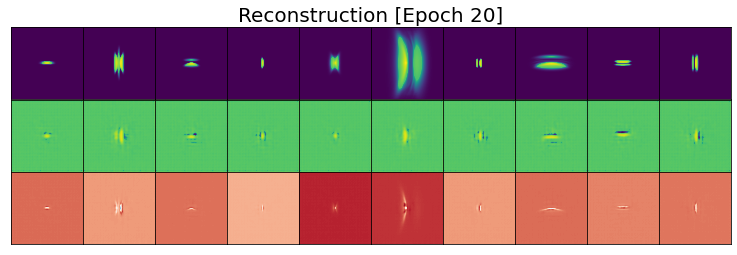

In [41]:
trainer.train(
        train_loader, val_loader, 20, save=True, early_stop=False
    )

In [27]:
trainer.test_loss

{'Loss_AE': [], 'Loss_R': [], 'Loss': []}

In [ ]:
trainer